In [1]:
!pip install bing_image_downloader

## Cargar imagenes

In [42]:
from bing_image_downloader import downloader
import os
import shutil

# Define los términos de búsqueda y la cantidad de imágenes a descargar para cada uno
search_terms = ['perro', 'flor', 'zapato']
total_images_per_term = 1000
# Crea una carpeta base para almacenar las imágenes
output_dir = 'dataset'



if not os.path.exists(output_dir):
    os.makedirs(output_dir)
else:
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)

# Función para renombrar y mover las imágenes descargadas
def rename_and_move_images(term, output_dir, count):
    term_dir = os.path.join(output_dir, term)
    images = os.listdir(term_dir)

    for idx, image in enumerate(images):

        base_name, extension = os.path.splitext(image)

        # Generar el nuevo nombre usando la extensión original
        new_name = f"{term}_{count + idx + 1}{extension}"
        os.rename(os.path.join(term_dir, image), os.path.join(output_dir, new_name))

    # Elimina la carpeta del término original
    shutil.rmtree(term_dir)

# Descargar y renombrar imágenes para cada término de búsqueda
for term in search_terms:
    downloader.download(term, limit=total_images_per_term, output_dir=output_dir, adult_filter_off=False, force_replace=False, timeout=60)
    rename_and_move_images(term, output_dir, 0)

print("Descarga y renombrado de imágenes completado.")


[%] Downloading Images to /content/dataset/perro


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from http://4.bp.blogspot.com/-xTEjs5Vi4v4/UD-RT2y9eFI/AAAAAAAAi30/vwfksN9fKvE/s1600/Perro-Pitbull_Fondos-de-Pantalla-HD-de-Perros.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.pinimg.com/originals/27/d6/33/27d6332add97c24febd69753b55b7f10.png
[%] File Downloaded !

[%] Downloading Image #3 from https://st3.depositphotos.com/7857468/12635/v/950/depositphotos_126355876-stock-illustration-cute-little-dog-cartoon.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://imagenes-tiernas.net/wp-content/uploads/2011/10/perro-lindo-labrador-marron.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.pinimg.com/originals/2b/c6/6d/2bc66d5189eef43a239f3a470fbfe82e.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://upload.wikimedia.org/wikipedia/commons/d/dc/Canis_lupus_familiaris_Perro_Mestizo.JPG
[%] File Down

## Preprocesamiento de imagenes

In [44]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_and_preprocess_images(folder_path, size=(224, 224)):
    images = []
    paths = []
    for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      print(f"Procesando: {file_path}")  # Depuración
      img = cv2.imread(file_path)
      if img is not None:
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, size)  # Normalizar tamaño
        img = np.float32(img) / 255.0  # Normalización
        images.append(img)
        paths.append(file_path)
      else:
        print(f"No se pudo leer la imagen: {file_path}")

    # Convertir la lista de imágenes a un array de numpy y cambiar la forma
    images = np.array(images)
    images = images.reshape(len(images), -1)  # Cambio de forma
    return images, paths

folder_path = 'dataset'
images, paths = load_and_preprocess_images(folder_path)

#pickle.dump(files, open( "raw_images.pkl", "wb" ) )


Procesando: dataset/flor_154.jpg
Procesando: dataset/perro_157.jpg
Procesando: dataset/flor_50.jpg
Procesando: dataset/zapato_192.jpg
Procesando: dataset/zapato_71.png
Procesando: dataset/perro_98.jpeg
Procesando: dataset/perro_104.jpg
Procesando: dataset/flor_68.png
Procesando: dataset/flor_64.jpg
Procesando: dataset/flor_12.jpg
Procesando: dataset/zapato_17.jpg
Procesando: dataset/perro_153.jpg
Procesando: dataset/zapato_129.jpg
Procesando: dataset/perro_74.jpg
Procesando: dataset/flor_43.jpg
Procesando: dataset/flor_155.jpg
Procesando: dataset/zapato_48.jpg
Procesando: dataset/flor_53.png
Procesando: dataset/zapato_148.jpg
Procesando: dataset/perro_7.jpg
Procesando: dataset/flor_60.png
Procesando: dataset/perro_67.jpg
Procesando: dataset/zapato_122.jpg
Procesando: dataset/zapato_179.jpg
Procesando: dataset/zapato_115.jpg
Procesando: dataset/zapato_61.jpg
Procesando: dataset/zapato_167.jpg
Procesando: dataset/zapato_158.jpg
Procesando: dataset/zapato_96.jpg
Procesando: dataset/flor_5

## Extraccion de caracteristicas

In [45]:
import tensorflow as tf
import pickle

#images = pickle.load( open( "preprocessed_images.pkl", "rb" ) )
model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
predictions = model.predict(images.reshape(-1, 224, 224, 3))
pred_images = predictions.reshape(images.shape[0], -1)

19/19 [==============================] - 26s 1s/step


In [43]:
print(pred_images[0].shape[0])

62720


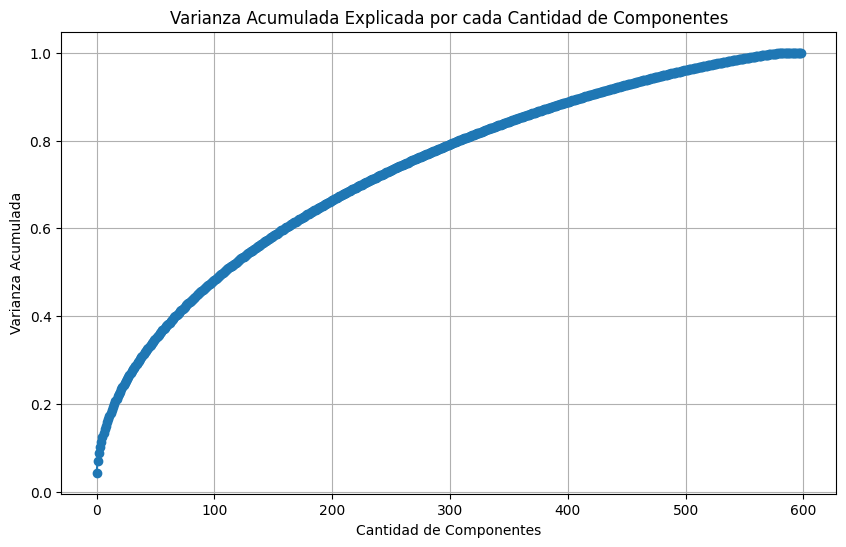

In [46]:
pca = PCA()
pca.fit(pred_images)

# Calcular la varianza acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Graficar la varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada por cada Cantidad de Componentes')
plt.xlabel('Cantidad de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid()
plt.show()

In [47]:
pca = PCA(n_components=500)
reduced_features = pca.fit_transform(pred_images)

## Prediccion

In [48]:

from sklearn.cluster import KMeans

# Clustering final
k = 3
kmodel = KMeans(n_clusters=k, random_state=728)
kmodel.fit(reduced_features)
kpredictions = kmodel.predict(reduced_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
with open('kmeans.pkl', 'wb') as fh:
   pickle.dump(kmodel, fh)

with open('mnv2.pkl', 'wb') as fh:
   pickle.dump(model, fh)

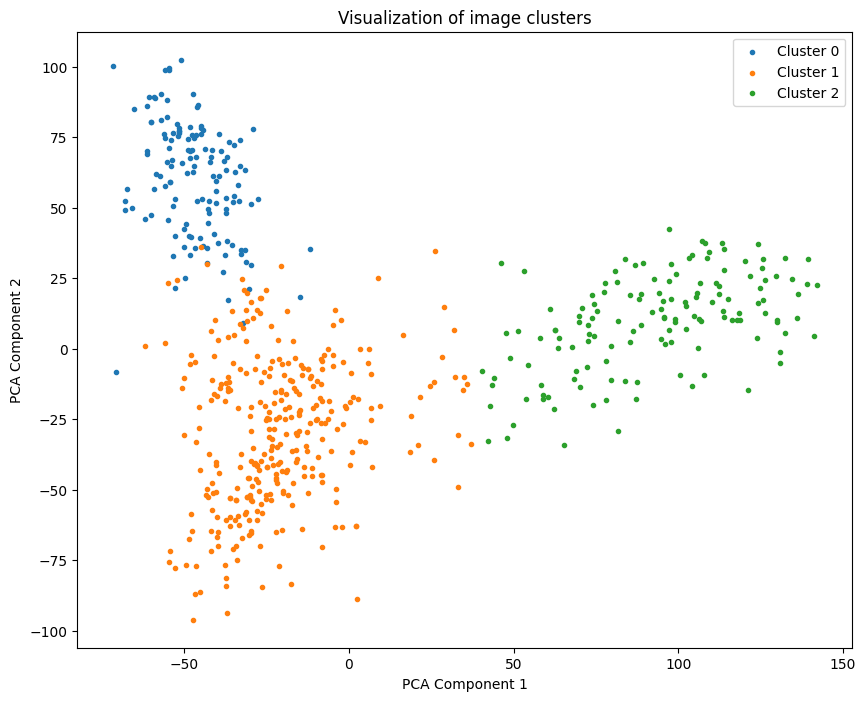

In [50]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pred_images)

plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(pca_result[kpredictions == i, 0], pca_result[kpredictions == i, 1], label=f'Cluster {i}', marker='.')
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualization of image clusters')
plt.show()

## Evaluacion de resultados

In [51]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Evaluar la calidad del clustering
silhouette_avg = silhouette_score(pred_images, kpredictions)
calinski_harabasz = calinski_harabasz_score(pred_images, kpredictions)
davies_bouldin = davies_bouldin_score(pred_images, kpredictions)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.021484635770320892
Calinski-Harabasz Index: 18.624678210859862
Davies-Bouldin Index: 4.927339811299208


In [52]:
base_dir = 'output'


if os.path.exists(base_dir):
  shutil.rmtree(base_dir)

os.makedirs(base_dir)
for i in range(k):
	os.makedirs(base_dir + "/cluster" + str(i))
for i in range(len(paths)):
	shutil.copy2(paths[i], base_dir + "/cluster"+str(kpredictions[i]))

In [53]:
def find_all_classes(cluster_n):
  flores = [ flor for flor in cluster_n if 'flor' in flor]
  perros = [ perro for perro in cluster_n if 'perro' in perro]
  zapatos = [ zapato for zapato in cluster_n if 'zapato' in zapato]

  return flores, perros, zapatos

cluster0 = os.listdir(base_dir + '/cluster0')
cluster1 = os.listdir(base_dir + '/cluster1')
cluster2 = os.listdir(base_dir + '/cluster2')


flores0, perros0, zapatos0 = find_all_classes(cluster0)
print("------------- Cluster 0")
print("Flores: ", len(flores0))
print("perros: ", len(perros0))
print("Zapatos: ", len(zapatos0))

flores1, perros1, zapatos1 = find_all_classes(cluster1)
print("------------- Cluster 1")
print("Flores: ", len(flores1))
print("perros: ",len(perros1))
print("Zapatos: ", len(zapatos1))

flores2, perros2, zapatos2 = find_all_classes(cluster2)
print("------------- Cluster 2")
print("Flores: ", len(flores2))
print("perros: ", len(perros2))
print("Zapatos: ", len(zapatos2))

------------- Cluster 0
Flores:  135
perros:  1
Zapatos:  0
------------- Cluster 1
Flores:  65
perros:  199
Zapatos:  57
------------- Cluster 2
Flores:  0
perros:  0
Zapatos:  142
